In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [12]:
filename = './Output_2018_2021_Braidwood_periodic/synthetic.csv'
synthetic_df = pd.read_csv(filename)
tag = filename.split('/')[1][7:]
synthetic_df.head()
#only keep first 4 years of data
synthetic_df = synthetic_df[synthetic_df['Year']<=2021]
# Remove useless data
synthetic_df.drop(columns=['scaling', 'RAVEN_sample_ID','prefix', 'PointProbability', 'ProbabilityWeight'], inplace=True)
synthetic_df

,Year,hour,price
0,2018,1,32.060767
1,2018,2,74.936480
2,2018,3,202.614220
3,2018,4,44.115569
4,2018,5,145.689894
...,...,...,...
35035,2021,8756,35.809725
35036,2021,8757,34.840783
35037,2021,8758,27.441728
35038,2021,8759,27.594318


In [31]:
# Read and concatenate historical data
files = ['2018_Braidwood.csv', '2019_Braidwood.csv', '2020_Braidwood.csv', '2021_Braidwood.csv']
li = []
for f in files: 
  df = pd.read_csv(f, index_col=None, header=0)
  li.append(df)
hist_df = pd.concat(li, axis=0, ignore_index=True)
hist_df.drop(columns=['hour'], inplace=True)
# Add time info to historic prices
time_df = synthetic_df.drop(columns=['price'])
historic_df = pd.concat([hist_df, time_df], axis=1)
historic_df

,price,Year,hour
0,259.890000,2018,1
1,112.930000,2018,2
2,192.669999,2018,3
3,103.430001,2018,4
4,214.030000,2018,5
...,...,...,...
35035,23.410000,2021,8756
35036,22.450000,2021,8757
35037,22.070000,2021,8758
35038,21.040000,2021,8759


In [58]:
# Statistic summary
hist_df.rename({'price':'historical price'}, axis=1, inplace=True)
temp_df = pd.concat([hist_df,synthetic_df], axis=1)
temp_df.rename({'price':'synthetic price'}, axis=1, inplace=True)
temp_df.drop(columns=['Year','hour'], inplace=True)
stats = dict(temp_df.describe())
#stats_df.append() = temp_df.kurtosis(axis=0)
for k,v in stats.items(): 
  stats[k] = dict(v)
#stats['historical price'] = dict(stats['historical price'])
# Add kurtosis
stats['historical price']['kurtosis'] = float(hist_df.kurtosis(axis = 0))
stats['synthetic price']['kurtosis'] = float(synthetic_df['price'].kurtosis(axis = 0))
# Add skewness
stats['historical price']['skewness'] = float(hist_df.skew(axis = 0))
stats['synthetic price']['skewness'] = float(synthetic_df['price'].skew(axis = 0))
stats_df = pd.DataFrame(stats)
stats_df.to_excel('ARMA_stats.xlsx',sheet_name=tag)

In [30]:
# Concatenate historic and synthetic prices with a tag
pieces = {'historical': historic_df, 'synthetic':synthetic_df}
prices_df = pd.concat(pieces, names=["type"])
prices_df = prices_df.reset_index(level=0)
prices_df

,price,Year,hour
count,70080.000000,70080.000000,70080.000000
mean,30.100637,2019.500000,4380.500000
std,24.315236,1.118042,2528.812205
min,-52.770000,2018.000000,1.000000
25%,19.220000,2018.750000,2190.750000
50%,24.170000,2019.500000,4380.500000
75%,32.929385,2020.250000,6570.250000
max,690.030000,2021.000000,8760.000000


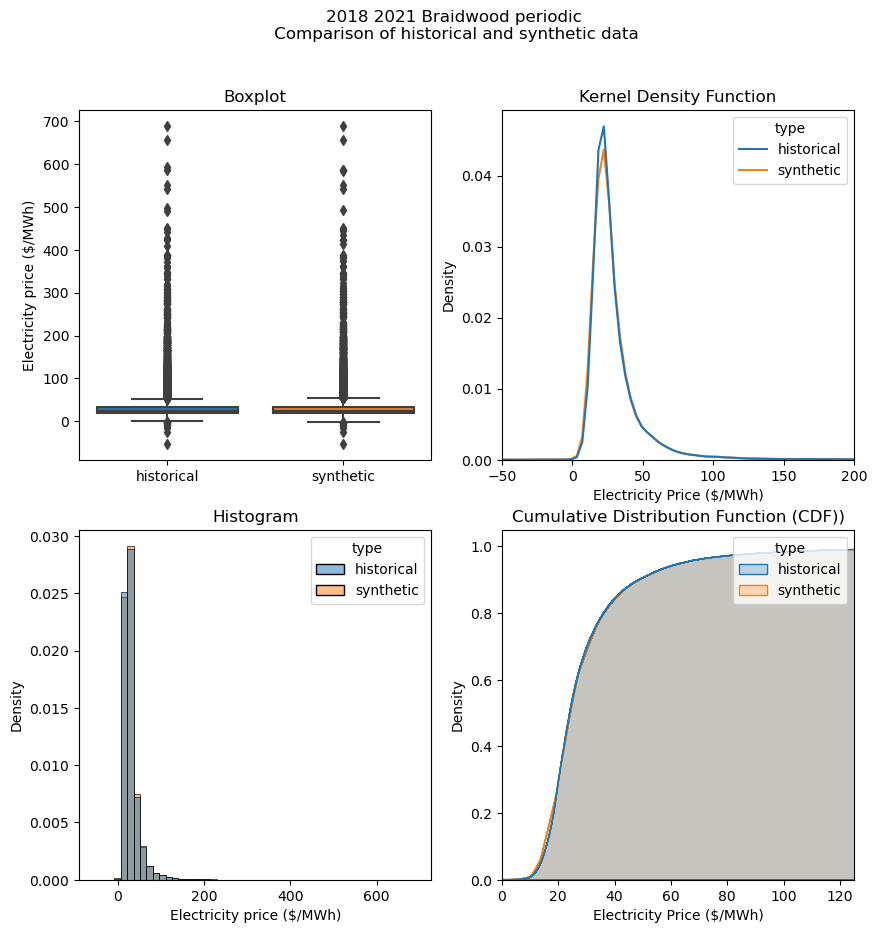

In [29]:
# Plot and save histograms and boxplots
fig, axes = plt.subplots(2,2,figsize =(10,10))

title = ' '.join(tag.split('_'))+'\n Comparison of historical and synthetic data'
fig.suptitle(title)

sns.boxplot(ax = axes[0,0],data=prices_df, x='type', y='price')
axes[0,0].set_title('Boxplot')
axes[0,0].set_ylabel('Electricity price ($/MWh)')
axes[0,0].set_xlabel('')

sns.histplot(ax = axes[1,0], data=prices_df, x='price', hue='type', bins=50, stat='density', common_norm=False)
axes[1,0].set_title('Histogram')
axes[1,0].set_xlabel('Electricity price ($/MWh)')

sns.kdeplot(ax = axes[0,1], x='price', data=prices_df, hue='type',common_norm=False)
axes[0,1].set_title('Kernel Density Function')
axes[0,1].set_xlabel('Electricity Price ($/MWh)')
axes[0,1].set_xlim(-50,200)

sns.histplot(ax = axes[1,1], data=prices_df, x='price', hue='type', bins=len(prices_df), stat='density', element='step', fill=True,cumulative=True, common_norm=False)
axes[1,1].set_title('Cumulative Distribution Function (CDF))')
axes[1,1].set_xlabel('Electricity Price ($/MWh)')
axes[1,1].set_xlim(0,125)

fig.savefig(tag+'_comparison_plots.png')

